In [1]:
import sys
sys.path.append('../')

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from lift.datasets import load_all_mad_datasets, compute_features, mad_labels_to_actions

from configs import BaseConfig

In [3]:
config = BaseConfig()
mad_windows, mad_labels = load_all_mad_datasets(
    config.mad_base_path.as_posix(),
    num_channels=config.n_channels,
    emg_range=config.emg_range,
    window_size=config.window_size,
    window_overlap=config.window_overlap,
    desired_labels=config.desired_mad_labels,
    skip_person='Female0',
    return_tensors=True,
)
mad_actions = mad_labels_to_actions(
        mad_labels, recording_strength=config.simulator.recording_strength,
)
mad_features = compute_features(mad_windows, feature_list = ['MAV'])

MAD dataset loaded


In [4]:
class Interpolator:
    def __init__(self, features, actions):
        self.features = features
        self.actions = actions
        self.epsilon = 1e-5

    def __call__(self, new_actions):
        # Step 1: Calculate distances for each new action
        # This results in a (batch_size, num_samples) distance matrix
        distances = np.linalg.norm(self.actions - new_actions[:, np.newaxis, :], axis=2)

        # Step 2: Compute interpolation weights
        weights = 1 / (distances + self.epsilon)
        weights /= weights.sum(axis=1, keepdims=True)

        # Step 3: Interpolate features
        interpolated_features_batch = np.tensordot(weights, self.features, axes=(1, 0))
        return interpolated_features_batch

In [5]:
idx1 = 1000
idx2 = 2000

interpolator = Interpolator(mad_features[[idx1, idx2]], mad_actions[[idx1, idx2]])

sample_action = mad_actions[[idx1, idx2]].sum(dim=0).unsqueeze(0)
sample_features = interpolator(sample_action)

Text(0.5, 1.0, 'Interpolation')

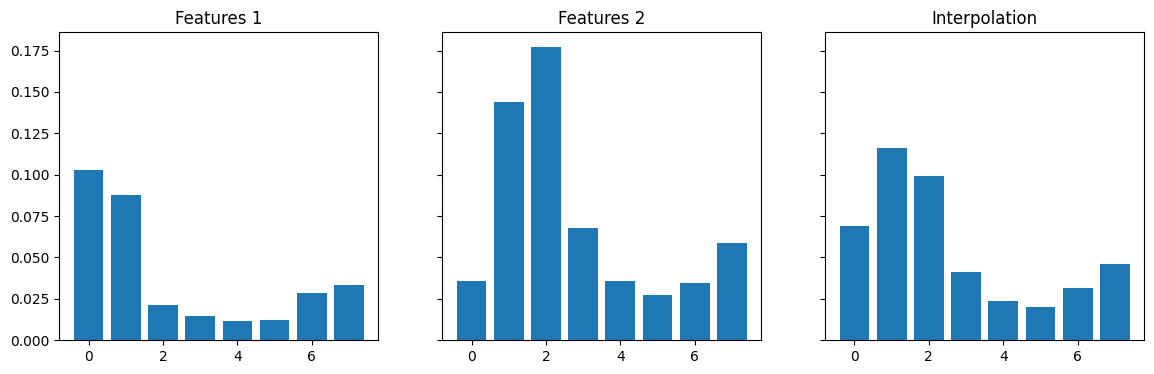

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
axs[0].bar(np.arange(8), mad_features[idx1])
axs[1].bar(np.arange(8), mad_features[idx2])
axs[2].bar(np.arange(8), sample_features[0])

axs[0].set_title(f'Features 1')
axs[1].set_title(f'Features 2')
axs[2].set_title('Interpolation')

In [178]:
interpolator = Interpolator(mad_features, mad_actions)

Text(0.5, 1.0, 'Interpolated features')

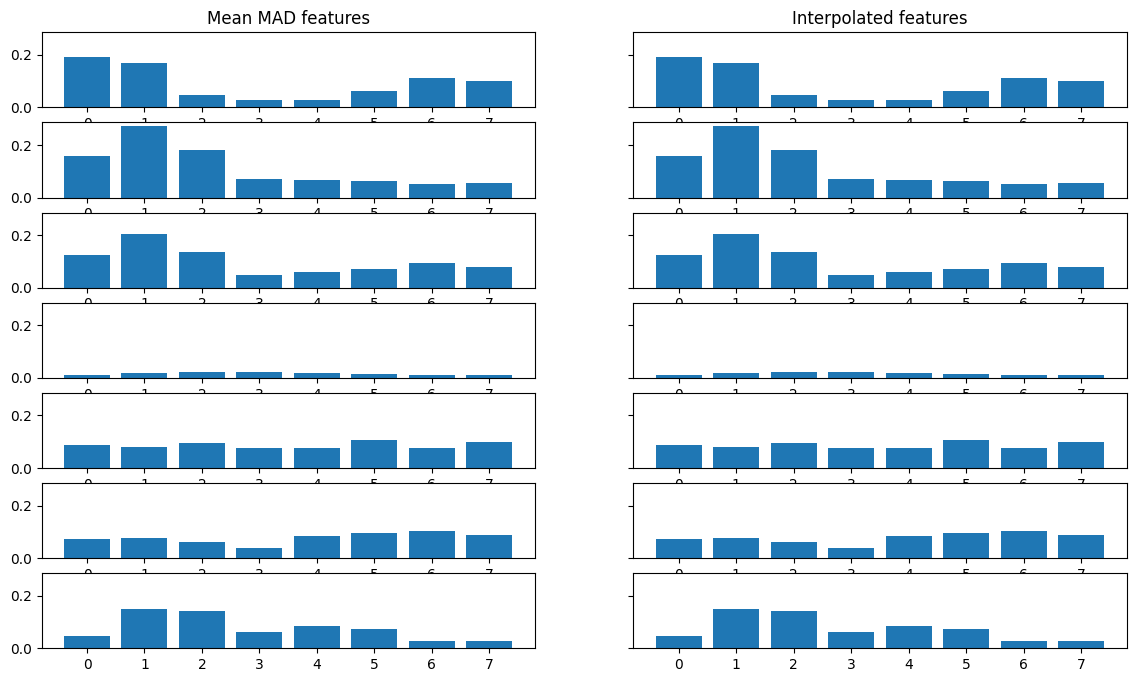

In [179]:
fig, axs = plt.subplots(7, 2, figsize=(14, 8), sharey=True)

for i, u_action in enumerate(mad_actions.unique(dim=0)):
    action_idx = torch.where((mad_actions==u_action).all(dim=1))[0]
    action_features = mad_features[action_idx].mean(dim=0)

    sample_action_features = interpolator(u_action.unsqueeze(0))

    axs[i,0].bar(np.arange(8), action_features)
    axs[i,1].bar(np.arange(8), sample_action_features[0])

axs[0,0].set_title(f'Mean MAD features')
axs[0,1].set_title(f'Interpolated features')

In [180]:
sample_actions = torch.rand(10_000, 3)

In [181]:
sample_features = interpolator(sample_actions)
sample_features = torch.from_numpy(sample_features)

In [5]:
from tqdm import tqdm
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.Dropout(dropout))
        layers.append(nn.ReLU())
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        out = self.network(x)
        return out

In [6]:
def train(model, features, actions, batch_size, epochs, lr):
    train_features = features[:-200]
    train_actions = actions[:-200]
    test_features = features[-200:]
    test_actions = actions[-200:]

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.)

    history = {"train_loss": [], "train_mae": [], "val_loss": [], "val_mae": []}
    bar = tqdm(range(epochs))
    for e in bar:
        sample_idx = torch.randint(len(train_features), size=(batch_size,))
        features_batch = train_features[sample_idx]
        actions_batch = train_actions[sample_idx]
        pred = model(features_batch)
        loss = nn.SmoothL1Loss().forward(pred, actions_batch)
        mae = torch.abs(pred - actions_batch).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        with torch.no_grad():
            val_pred = model(test_features)
            val_loss = nn.SmoothL1Loss().forward(val_pred, test_actions)
            val_mae = torch.abs(val_pred - test_actions).mean()

        bar.set_description(f"e: {e}, train_loss: {loss:.2f}, val_loss: {val_loss:.2f}")
        history["train_loss"].append(loss.data.item())
        history["train_mae"].append(mae.data.item())
        history["val_loss"].append(val_loss.data.item())
        history["val_mae"].append(val_mae.data.item())
    return history

In [184]:
batch_size = 512
epochs = 20_000
lr = 3e-4

model = MLP(8, 3, [512, 512], 0.1)
sample_history = train(model, sample_features, sample_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.00: 100%|██████████| 20000/20000 [02:02<00:00, 162.68it/s]


In [185]:
model = MLP(8, 3, [512, 512], 0.1)
mad_history = train(model, mad_features, mad_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.01: 100%|██████████| 20000/20000 [02:02<00:00, 162.80it/s]


In [193]:
model = MLP(8, 3, [512, 512], 0.1)
combined_features = torch.cat((sample_features, mad_features), dim=0)
combined_actions = torch.cat((sample_actions, mad_actions), dim=0)
combined_history = train(model, combined_features, combined_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.01: 100%|██████████| 20000/20000 [02:05<00:00, 159.80it/s]


Text(0.5, 1.0, 'Combined')

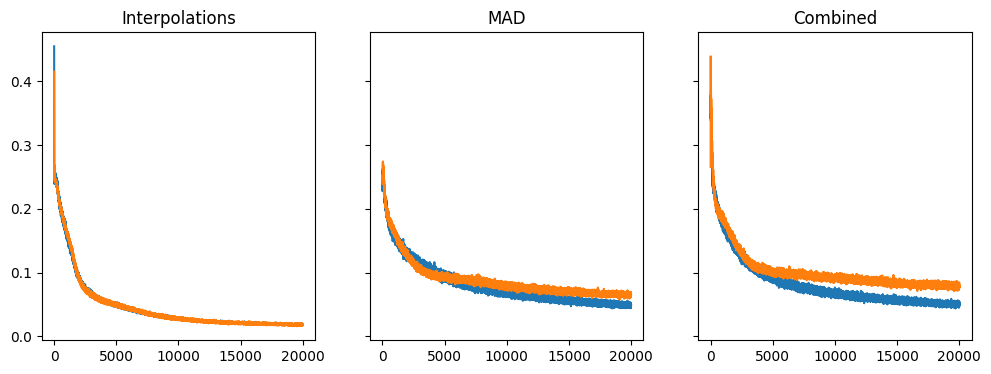

In [196]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
axs[0].plot(sample_history['train_mae'])
axs[0].plot(sample_history['val_mae'])
axs[1].plot(mad_history['train_mae'])
axs[1].plot(mad_history['val_mae'])
axs[2].plot(combined_history['train_mae'])
axs[2].plot(combined_history['val_mae'])

axs[0].set_title('Interpolations')
axs[1].set_title('MAD')
axs[2].set_title('Combined')

In [7]:
people_list = [f"Female{i}" for i in range(10)] + [f"Male{i}" for i in range(16)]

In [9]:
mad_features = None
mad_actions = None
sample_features = None
sample_actions = None

for p in people_list:
    other_list = [o_p for o_p in people_list if not o_p == p]
    person_windows, person_labels = load_all_mad_datasets(
        config.mad_base_path.as_posix(),
        num_channels=config.n_channels,
        emg_range=config.emg_range,
        window_size=config.window_size,
        window_overlap=config.window_overlap,
        desired_labels=config.desired_mad_labels,
        skip_person=other_list,
        return_tensors=True,
    )

    person_features = compute_features(person_windows, feature_list = ['MAV'])
    person_actions = mad_labels_to_actions(
            person_labels, recording_strength=config.simulator.recording_strength,
        )

    p_interpolator = Interpolator(person_features, person_actions)

    p_sample_action = torch.rand(1000, 3)
    p_sample_features = p_interpolator(p_sample_action)
    p_sample_features = torch.from_numpy(p_sample_features)

    if mad_features is None:
        mad_features = person_features
        mad_actions = person_actions
        sample_features = p_sample_features
        sample_actions = p_sample_action
    else:
        mad_features = torch.cat((mad_features, person_features), dim=0)
        mad_actions = torch.cat((mad_actions, person_actions), dim=0)
        sample_features = torch.cat((sample_features, p_sample_features), dim=0)
        sample_actions = torch.cat((sample_actions, p_sample_action), dim=0)

MAD dataset loaded
torch.Size([726, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([153, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([182, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD dataset loaded
torch.Size([728, 8, 200])
MAD datase

In [11]:
sample_features.shape, sample_actions.shape

(torch.Size([26000, 8]), torch.Size([26000, 3]))

In [13]:
batch_size = 512
epochs = 20_000
lr = 3e-4

model = MLP(8, 3, [512, 512], 0.1)
sample_history = train(model, sample_features, sample_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.01, val_loss: 0.01: 100%|██████████| 20000/20000 [02:14<00:00, 148.87it/s]


In [14]:
model = MLP(8, 3, [512, 512], 0.1)
mad_history = train(model, mad_features, mad_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.02: 100%|██████████| 20000/20000 [02:18<00:00, 144.62it/s]


In [15]:
model = MLP(8, 3, [512, 512], 0.1)
combined_features = torch.cat((sample_features, mad_features), dim=0)
combined_actions = torch.cat((sample_actions, mad_actions), dim=0)
combined_history = train(model, combined_features, combined_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.01, val_loss: 0.02: 100%|██████████| 20000/20000 [02:16<00:00, 146.44it/s]


In [20]:
model = MLP(8, 3, [512, 512], 0.1)
single_p_history = train(model, sample_features[:1000], sample_actions[:1000], batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.00: 100%|██████████| 20000/20000 [02:09<00:00, 154.80it/s]


In [21]:
model = MLP(8, 3, [512, 512], 0.1)
single_p_mad_history = train(model, mad_features[:726], mad_actions[:726], batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.00: 100%|██████████| 20000/20000 [02:10<00:00, 153.11it/s]


In [ ]:
model = MLP(8, 3, [512, 512], 0.1)
single_p_combined_features = torch.cat((sample_features[:1000], mad_features[:726]), dim=0)
single_p_combined_actions = torch.cat((sample_actions[:1000], mad_actions[:726]), dim=0)
single_p_combined_history = train(model, single_p_combined_features, single_p_combined_actions, batch_size, epochs, lr)

e: 19999, train_loss: 0.00, val_loss: 0.00: 100%|██████████| 20000/20000 [02:13<00:00, 150.28it/s]


In [26]:
single_p_history['val_mae'][-1]

0.018279600888490677

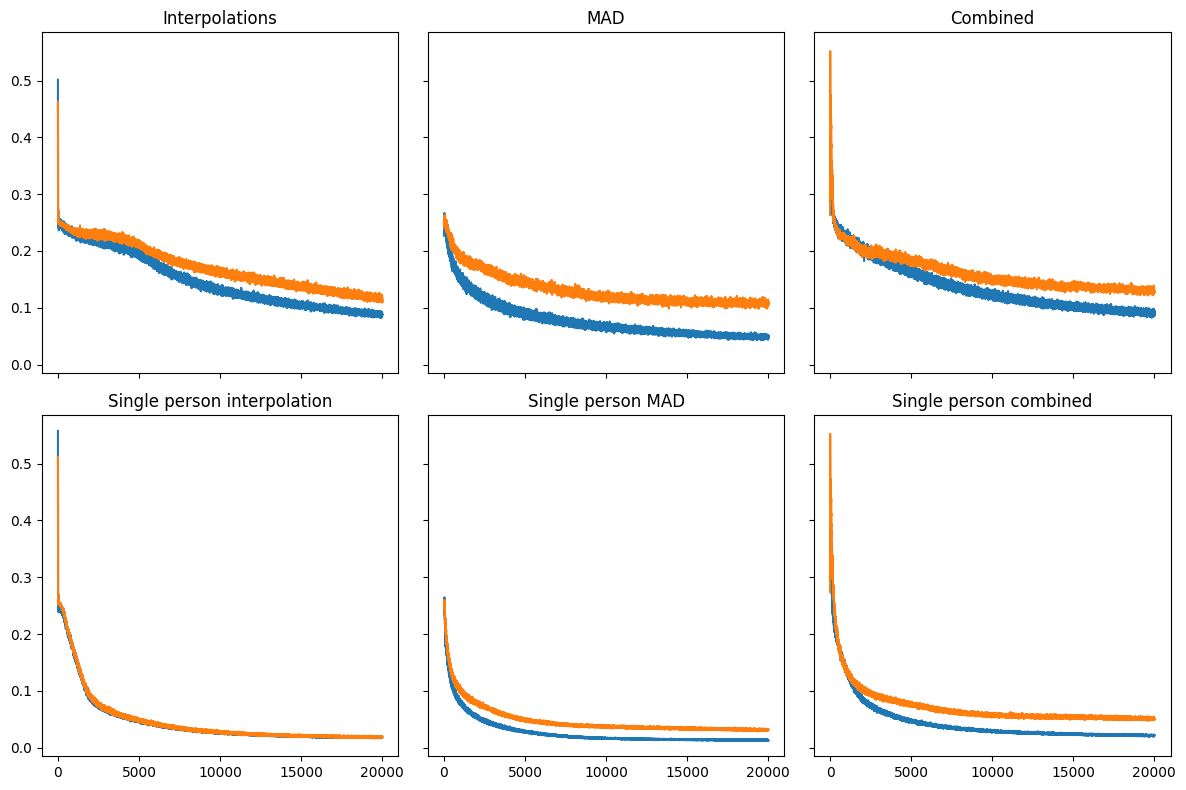

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(12,8), sharex=True, sharey=True)
axs[0,0].plot(sample_history['train_mae'])
axs[0,0].plot(sample_history['val_mae'])
axs[0,1].plot(mad_history['train_mae'])
axs[0,1].plot(mad_history['val_mae'])
axs[0,2].plot(combined_history['train_mae'])
axs[0,2].plot(combined_history['val_mae'])
axs[1,0].plot(single_p_history['train_mae'])
axs[1,0].plot(single_p_history['val_mae'])
axs[1,1].plot(single_p_mad_history['train_mae'])
axs[1,1].plot(single_p_mad_history['val_mae'])
axs[1,2].plot(single_p_combined_history['train_mae'])
axs[1,2].plot(single_p_combined_history['val_mae'])

axs[0,0].set_title('Interpolations')
axs[0,1].set_title('MAD')
axs[0,2].set_title('Combined')
axs[1,0].set_title('Single person interpolation')
axs[1,1].set_title('Single person MAD')
axs[1,2].set_title('Single person combined')
plt.tight_layout()